# Importing Data Example

In order to import data into `pypillometry`, we have to load the data from the source using other packages and then wrap it into `PupilData` objects. 

Here we will show and example where we translate a file recorded in Eyelinks EDF-format to a file readable by `pandas.read_table()`.

First, we import the needed modules.

In [2]:
import sys, os
sys.path.insert(0,"..") # this is not needed if you have installed pypillometry
import pypillometry as pp
import pandas as pd
import numpy as np
import pylab as plt

In this example, we use data recorded with an Eyelink-eyetracker. These eyetrackers store the files in binary files with the extension `.edf`. Some information about this file-format is [here](http://download.sr-support.com/dispdoc/page25.html). We use a command-line utility released by Eyelink to convert this proprietory format into a more easily read `.asc` file that is a whitespace-separated plain-text format. The converter, `edf2asc` is a program that can be downloaded for different platforms from the [Eyelink support forum](https://www.sr-research.com/support/). There is a GUI-based program for windows and command-line programs for linux and mac. Binaries of the command-line tools for linux and mac are included in `pypillometry` under [this link](https://github.com/ihrke/pypillometry/tree/master/external). 

On linux, we would call these programs on an example edf-file twice as follows. 

In [1]:
!../external/edf2asc-mac -y -s ../data/test.edf ../data/test_samples.asc
!../external/edf2asc-mac -y -e ../data/test.edf ../data/test_events.asc


EDF2ASC: EyeLink EDF file -> ASCII (text) file translator
EDF2ASC version 3.1 MacOS X Jul 13 2010 
(c)1995-2009 by SR Research, last modified Jul 13 2010

processing file ../data/test.edf 
=======================Preamble of file ../data/test.edf=======================
| DATE: Fri Feb 14 08:48:33 2020                                              |
| TYPE: EDF_FILE BINARY EVENT SAMPLE TAGGED                                   |
| VERSION: EYELINK II 1                                                       |
| SOURCE: EYELINK CL                                                          |
| EYELINK II CL v6.12 Feb  1 2018 (EyeLink Portable Duo)                      |
| CAMERA: EyeLink USBCAM Version 1.01                                         |
| SERIAL NUMBER: CLU-DAC49                                                    |
| CAMERA_CONFIG: DAC49200.SCD                                                 |
| Psychopy GC demo                                                            |

Converted

This results in two files, one containing all the samples and one all the recorded events.

In [3]:
fname_samples="../data/test_samples.asc"
fname_events="../data/test_events.asc"

The samples-files contains a large table containing the timestamp, x/y-coordinates for the eyeposition and pupil-area for both the left and the right eye. Here are the first few rows of this file:

In [4]:
!head $fname_samples

3385900	  817.3	  345.2	 1707.0	  860.6	  375.2	 1738.0	.....
3385902	  817.0	  343.5	 1706.0	  860.7	  375.9	 1739.0	.....
3385904	  816.7	  341.6	 1705.0	  861.2	  376.6	 1739.0	.....
3385906	  816.7	  340.4	 1706.0	  861.7	  376.8	 1740.0	.....
3385908	  816.7	  340.2	 1707.0	  861.6	  376.9	 1742.0	.....
3385910	  816.8	  340.2	 1708.0	  861.1	  377.1	 1743.0	.....
3385912	  816.9	  340.9	 1708.0	  860.7	  377.5	 1744.0	.....
3385914	  816.1	  342.1	 1710.0	  861.1	  378.7	 1745.0	.....
3385916	  815.2	  343.2	 1712.0	  862.5	  380.0	 1746.0	.....
3385918	  814.4	  343.6	 1713.0	  863.9	  380.7	 1747.0	.....


We can easily read this file using `pandas.read_csv()`.

In [5]:
df=pd.read_table(fname_samples, index_col=False, 
                  names=["time", "left_x", "left_y", "left_p", 
                         "right_x", "right_y", "right_p"])
df

,time,left_x,left_y,left_p,right_x,right_y,right_p
0,3385900,817.3,345.2,1707.0,860.6,375.2,1738.0
1,3385902,817.0,343.5,1706.0,860.7,375.9,1739.0
2,3385904,816.7,341.6,1705.0,861.2,376.6,1739.0
3,3385906,816.7,340.4,1706.0,861.7,376.8,1740.0
4,3385908,816.7,340.2,1707.0,861.6,376.9,1742.0
...,...,...,...,...,...,...,...
1245358,5923060,.,.,0.0,.,.,0.0
1245359,5923062,.,.,0.0,.,.,0.0
1245360,5923064,.,.,0.0,.,.,0.0
1245361,5923066,.,.,0.0,.,.,0.0


We can already use this information to create our `PupilData`-object. We simply pass in the pupil-area of the right eye (column `right_p`) and the timestamp-array from the samples-file (Note: we could just as easily have used the left eye or the mean of both):

In [6]:
pp.PupilData(df.right_p, time=df.time, name="test")

> Filling in 5 gaps
[32.35   4.012  6.21   2.02   1.862] seconds


PupilData(test, 135.5MiB):
 n                 : 1268585
 nmiss             : 212551
 perc_miss         : 16.75496714843704
 nevents           : 0
 nblinks           : 0
 ninterpolated     : 0
 blinks_per_min    : 0.0
 fs                : 500.0
 duration_minutes  : 42.28616666666667
 start_min         : 56.431666666666665
 end_min           : 98.7178
 baseline_estimated: False
 response_estimated: False
 History:
 *

Of course, this dataset is still missing the important information contained in the event-file which we will use for analysing trial-related pupil-diameter data. For that, we will have to read the events-file, which has a more complicated structure than the samples-file: 

In [7]:
!head -20 $fname_events

** CONVERTED FROM ../data/test.edf using edfapi 3.1 MacOS X Jul 13 2010 on Wed May 27 16:45:20 2020
** DATE: Fri Feb 14 08:48:33 2020
** TYPE: EDF_FILE BINARY EVENT SAMPLE TAGGED
** VERSION: EYELINK II 1
** SOURCE: EYELINK CL
** EYELINK II CL v6.12 Feb  1 2018 (EyeLink Portable Duo)
** CAMERA: EyeLink USBCAM Version 1.01
** SERIAL NUMBER: CLU-DAC49
** CAMERA_CONFIG: DAC49200.SCD
** Psychopy GC demo
**

INPUT	2767568	0
MSG	2784000 !CAL 
>>>>>>> CALIBRATION (HV9,P-CR) FOR LEFT: <<<<<<<<<
MSG	2784000 !CAL Calibration points:  
MSG	2784000 !CAL -29.4, -23.5        -0,     -2   
MSG	2784000 !CAL -29.3, -35.7        -0,  -1544   
MSG	2784000 !CAL -32.9, -10.4        -0,   1559   
MSG	2784000 !CAL -49.7, -23.0     -2835,     -2   


After a header (lines starting with '\*\*') containing meta-information, we get a sequence of "events" which have different formats for all rows. We are interested in lines starting with "MSG" because those contain our experimental markers. Therefore, we read the samples file and remove all rows that do not start with "MSG" first:

In [8]:
# read the whole file into variable `events` (list with one entry per line)
with open(fname_events) as f:
    events=f.readlines()

# keep only lines starting with "MSG"
events=[ev for ev in events if ev.startswith("MSG")]
events[0:10]

['MSG\t2784000 !CAL \n',
 'MSG\t2784000 !CAL Calibration points:  \n',
 'MSG\t2784000 !CAL -29.4, -23.5        -0,     -2   \n',
 'MSG\t2784000 !CAL -29.3, -35.7        -0,  -1544   \n',
 'MSG\t2784000 !CAL -32.9, -10.4        -0,   1559   \n',
 'MSG\t2784000 !CAL -49.7, -23.0     -2835,     -2   \n',
 'MSG\t2784000 !CAL -10.8, -27.4      2835,     -2   \n',
 'MSG\t2784000 !CAL -48.3, -33.3     -2818,  -1544   \n',
 'MSG\t2784000 !CAL -11.0, -34.2      2818,  -1544   \n',
 'MSG\t2784000 !CAL -56.2, -9.2     -2852,   1559   \n']

Next, we added an experimental marker that was sent as the experiment was started. This marker was called `experiment_start`. Hence, we can remove all events before this marker.

In [9]:
experiment_start_index=np.where(["experiment_start" in ev for ev in events])[0][0]
events=events[experiment_start_index+1:]
events[0:10]

['MSG\t3387245 C_GW_1_1_UD_UD\n',
 'MSG\t3390421 F_GW_1_1_10_0\n',
 'MSG\t3392759 C_NW_1_2_UD_UD\n',
 'MSG\t3394293 R_NW_1_2_UD_UD\n',
 'MSG\t3395952 F_NW_1_2_-1_0\n',
 'MSG\t3397974 C_NA_1_3_UD_UD\n',
 'MSG\t3399892 R_NA_1_3_UD_UD\n',
 'MSG\t3400999 F_NA_1_3_-11_0\n',
 'MSG\t3403206 C_GA_1_4_UD_UD\n',
 'MSG\t3404640 R_GA_1_4_UD_UD\n']

This is in a format where we can convert it into a `pandas.DataFrame` object for further processing.

In [10]:
df_ev=pd.DataFrame([ev.split() for ev in events])
df_ev

,0,1,2,3,4,5,6,7,8
0,MSG,3387245,C_GW_1_1_UD_UD,None,None,None,None,None,None
1,MSG,3390421,F_GW_1_1_10_0,None,None,None,None,None,None
2,MSG,3392759,C_NW_1_2_UD_UD,None,None,None,None,None,None
3,MSG,3394293,R_NW_1_2_UD_UD,None,None,None,None,None,None
4,MSG,3395952,F_NW_1_2_-1_0,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
1065,MSG,5893078,V_UD_UD_16_UD_UD,None,None,None,None,None,None
1066,MSG,5899076,V_UD_UD_17_UD_UD,None,None,None,None,None,None
1067,MSG,5905073,V_UD_UD_18_UD_UD,None,None,None,None,None,None
1068,MSG,5911072,V_UD_UD_19_UD_UD,None,None,None,None,None,None


In this table, the second column contains the time-stamp (identical to the time-stamp in the samples file), and the third column contains our custom markers (the format like "C_GW_1_1_UD_UD" and so on is specific for our experimental design). There are many more columns which seem to contain no information in our samples. Let's check what those columns are for by printing the rows in our data-frame where these columns are not `None`:

In [11]:
df_ev[np.array(df_ev[4])!=None].head()

,0,1,2,3,4,5,6,7,8
209,MSG,3900393,RECCFG,CR,500,2,1,LR,None
211,MSG,3900393,GAZE_COORDS,0.00,0.00,1919.00,1079.00,None,None
212,MSG,3900393,THRESHOLDS,L,56,231,R,66,239
213,MSG,3900393,ELCL_WINDOW_SIZES,176,188,0,0,None,None
215,MSG,3900393,ELCL_PROC,CENTROID,(3),None,None,None,None


Apparently, there are more eye-tracker specific markers in our files (in this case due to drift-checks during the experiments). We can safely drop those from our set of interesting events by dropping all rows in which the fourth column is not `None` and then dropping all non-interesting columns.

In [12]:
df_ev=df_ev[np.array(df_ev[4])==None][[1,2]]
df_ev.columns=["time", "event"]
df_ev

,time,event
0,3387245,C_GW_1_1_UD_UD
1,3390421,F_GW_1_1_10_0
2,3392759,C_NW_1_2_UD_UD
3,3394293,R_NW_1_2_UD_UD
4,3395952,F_NW_1_2_-1_0
...,...,...
1065,5893078,V_UD_UD_16_UD_UD
1066,5899076,V_UD_UD_17_UD_UD
1067,5905073,V_UD_UD_18_UD_UD
1068,5911072,V_UD_UD_19_UD_UD


Finally, we can pass those event-markers into our `PupilData`-object.

In [13]:
d=pp.PupilData(df.right_p, time=df.time, event_onsets=df_ev.time, event_labels=df_ev.event, name="test")
d

> Filling in 5 gaps
[32.35   4.012  6.21   2.02   1.862] seconds


PupilData(test, 135.5MiB):
 n                 : 1268585
 nmiss             : 212551
 perc_miss         : 16.75496714843704
 nevents           : 1035
 nblinks           : 0
 ninterpolated     : 0
 blinks_per_min    : 0.0
 fs                : 500.0
 duration_minutes  : 42.28616666666667
 start_min         : 56.431666666666665
 end_min           : 98.7178
 baseline_estimated: False
 response_estimated: False
 History:
 *

The summary of the dataset shows us that the eyetracker started recording at time=56.4 minutes. We can reset the time index to start with 0 by using the `reset_time()` function.

In [14]:
d=d.reset_time().blinks_detect()

Now we can store away this dataset in `pypillometry`-format and use all the `pypillometry`-functions on it, e.g., plot a minute of this dataset.

In [16]:
d.sub_slice(4, 6, units="min").drop_original().write_file("../data/test.pd")

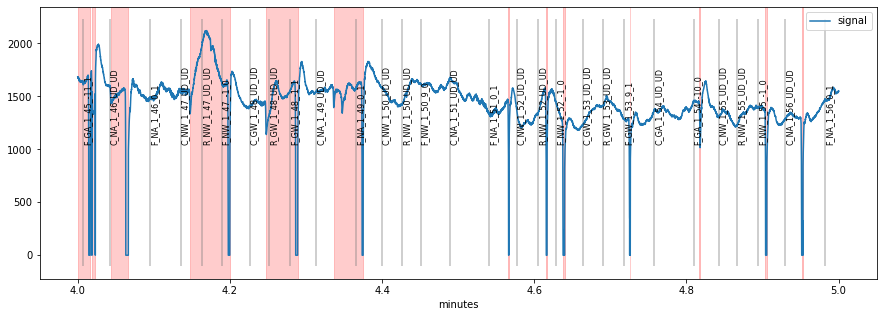

In [15]:
plt.figure(figsize=(15,5)); 
d.plot((4, 5), units="min")

## Generalize to multiple similar datasets

Now that we have successfully found a way to create our `PupilData` structure from the raw `.EDF` files, we can wrap the code from this notebook into an easily accessible function that creates `PupilData` objects for a given `.EDF` file that has the same structure.

We simply create a function that takes the name of an `EDF`-file as input and runs all the code above, returning the final `PupilData` object. For convenience, we will assume that the `EDF2ASC` utility has already run such that `.asc` files are already available (see above for details).

In [42]:
datapath="../data" ## this is where the datafiles are located

def read_dataset(edffile):
    basename=os.path.splitext(edffile)[0] ## remove .edf from filename
    fname_samples=os.path.join(datapath, basename+"_samples.asc")
    fname_events=os.path.join(datapath, basename+"_events.asc")
  
    print("> Attempt loading '%s' and '%s'"%(fname_samples, fname_events))
    ## read samples-file
    df=pd.read_table(fname_samples, index_col=False, 
                  names=["time", "left_x", "left_y", "left_p", 
                         "right_x", "right_y", "right_p"])
    
    ## read events-file
    # read the whole file into variable `events` (list with one entry per line)
    with open(fname_events) as f:
        events=f.readlines()

    # keep only lines starting with "MSG"
    events=[ev for ev in events if ev.startswith("MSG")]
    # remove events before experiment start
    experiment_start_index=np.where(["experiment_start" in ev for ev in events])[0][0]
    events=events[experiment_start_index+1:]

    # re-arrange as described above
    df_ev=pd.DataFrame([ev.split() for ev in events])
    df_ev=df_ev[np.array(df_ev[4])==None][[1,2]]
    df_ev.columns=["time", "event"]
    
    # create `PupilData`-object
    d=pp.PupilData(df.right_p, time=df.time, event_onsets=df_ev.time, event_labels=df_ev.event, name=edffile)
    return d


We can test this code by simply running the function with a certain filename located in `datapath`:

In [43]:
read_dataset("test.edf")

> Attempt loading '../data/test_samples.asc' and '../data/test_events.asc'
> Filling in 5 gaps
[32.35   4.012  6.21   2.02   1.862] seconds


PupilData(test.edf, 135.5MiB):
 n                 : 1268585
 nmiss             : 212551
 perc_miss         : 16.75496714843704
 nevents           : 1035
 nblinks           : 0
 ninterpolated     : 0
 blinks_per_min    : 0.0
 fs                : 500.0
 duration_minutes  : 42.28616666666667
 start_min         : 56.431666666666665
 end_min           : 98.7178
 baseline_estimated: False
 response_estimated: False
 History:
 *

## Storing/Loading several datasets

So now it is easy to read a set of datasets into a Python `list` from the same experimental setup with a simple loop, e.g.,

In [46]:
files=["test.edf", "test2.edf", "test3.edf"]
datasets=[read_dataset(fname) for fname in files]

> Attempt loading '../data/test_samples.asc' and '../data/test_events.asc'
> Filling in 5 gaps
[32.35   4.012  6.21   2.02   1.862] seconds


After that, we might want to save the final `PupilData` objects as `.pd` files that can be readily loaded back. Here, we loop through the list of datasets and store each of them in separate files using the `name` attribute of the object as filename.

In [47]:
for ds in datasets:
    fname=os.path.join(datapath, ds.name+".pd")
    ds.write_file(fname)

These datasets can be read back using the `PupilData.from_file()` method:

In [58]:
# all filenames in `datapath` that end with `.pd`
pd_files=[fname for fname in os.listdir(datapath) if fname.endswith(".pd")]
datasets=[]
for fname in pd_files:
    fname=os.path.join(datapath, fname)
    d=pp.PupilData.from_file(fname)
    datasets.append(d)

It is also possible to store the whole `list` as a single file by using the `pd_write_pickle()`-function:

In [60]:
pp.pd_write_pickle(datasets, "full_dataset.pd")

which can be read-back using the `pd_read_pickle()` function like so:

In [61]:
datasets=pp.pd_read_pickle("full_dataset.pd")